In [20]:
%matplotlib inline
import importlib
from IPython.display import clear_output
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import utils.architectures as architectures
from utils.basic_function import draw_labels
import utils.data as data
import utils.sub_architectures as sub_architectures


In [21]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
##### TRAINING UTILS / PLOTTING FUNCTIONS

### Trains a (sub-architecture) autoencoder given Model type
def train_subarchitecture(
    model, 
    optim, 
    lr, 
    num_epochs, 
    train_loader, 
    val_loader, 
    val_data,
    device,
    saved_model_filename,
    plot_training=False, 
    save_model=True,
):

    device = get_device()
    model = model.to(device=device)

    criterion = nn.MSELoss() #Loss function
    optimizer = optim(model.parameters(), lr=lr) #Optimizer

    lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min", 
        factor=0.1, 
        patience=2, 
        cooldown=1, 
        verbose=True)

    # Training
    train_loss = []
    model.train()
    
    print("Training Progress: ")
    time.sleep(0.5)

    for epoch in range(num_epochs):
        epoch_losses = []
        for x in tqdm(train_loader):

            x = x.to(device)
            outputs = model(x)

            loss = criterion(outputs, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.detach().cpu().numpy())

        clear_output(wait=True)
        train_loss.extend(epoch_losses)
        lr_schedule.step(np.mean(epoch_losses))
        
        if(plot_training):
            plt.plot(range(len(train_loss)), train_loss)
            plt.show()
            print(f"\rLoss After {epoch+1} Epochs: "+str(np.mean(epoch_losses)))
            if np.mean(epoch_losses) < 0.01:
                break

        if(save_model):
            model.save(filename=saved_model_filename)

    return model

### Plots "n" reconstructed images side-by-side with the original images
def show_n_reconstructed_images(model, output_images, n:int):

    numpy_images, numpy_output = output_images

    print("\nRendering Results...")

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(10,5*n))
    for idx in range(n):
        axes[idx, 0].imshow(numpy_images[idx])
        axes[idx, 0].set_title("Original Image")
        axes[idx, 1].set_title("Reconstructed Image")
        axes[idx, 1].imshow(numpy_output[idx])
        axes[idx, 1].set_title("Reconstructed Image")
        axes[idx, 2].imshow(abs(numpy_images[idx]-numpy_output[idx]))

    plt.show()

### Plots "n" Bounding Box predictions overlaying the target image
def show_n_bounding_box_results(approach, dataset, n:int):

    for i in range(n):
        print(f"Sample Nr. {i}:")
        sample = dataset[i]
        samples = [sample]

        res = approach.infer(samples, verbose=0, threshold=0.1)
        print(res)

        mid_img = sample.get_warped_photo(3,8)
        draw_labels(mid_img, [res[0], sample.labels])

### Returns a dataset depending on Architecture / Sub-Architecture training
def get_dataset(sub):
    if(sub):
        return data.RandomSamplingGridCutoutDataset(preprocess_image_options = {
            "use_mask": True,
            "equalize_hist": False,
            "crop_black": True,
            "match_histogram": False
        }, crop_shape=(128,128), resample_image_every_n_draws=50)
    else:
        return data.MultiViewTemporalDataset(mode = "validation", preprocess_image_options = {
            "use_mask": True,
            "equalize_hist": False,
            "crop_black": False,
            "match_histogram": False
        }, data_path="data")

### Evaluates the model for the Sub-Architecture case exclusively
def evaluate_model(model, train_loader, val_loader, device):
    images = next(iter(val_loader))
    numpy_images = images.numpy()

    #Sample outputs
    model.eval()
    numpy_output = model(images.to(device)).detach().cpu().numpy()

    numpy_images = np.transpose(numpy_images, (0, 2, 3, 1))
    numpy_output = np.transpose(numpy_output, (0, 2, 3, 1))

    return numpy_images, numpy_output


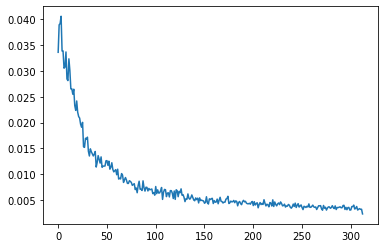

Loss After 1 Epochs: 0.007828583

Rendering Results...


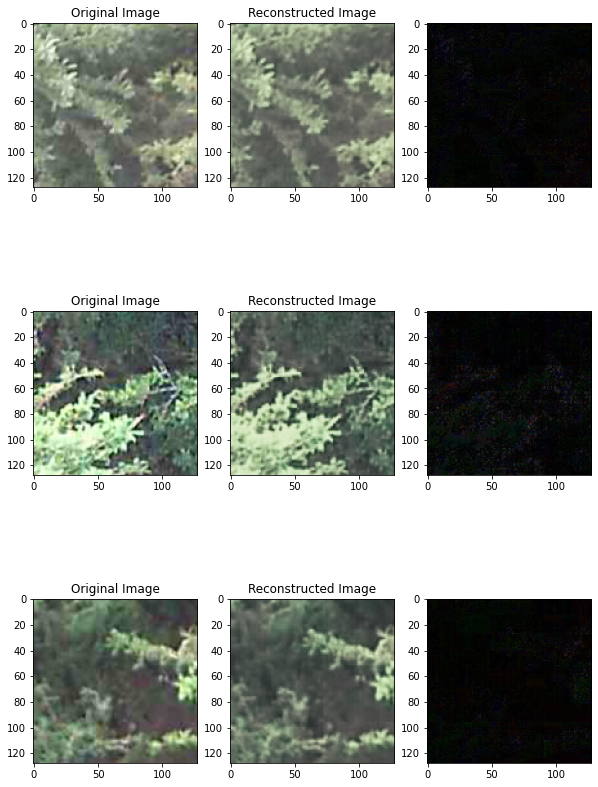

Device: NVIDIA GeForce GTX 1060 6GB
Sample Nr. 0:
[array([[645, 474,  27,  27],
       [656, 468,  27,  27],
       [624, 431,  39,  35]])]


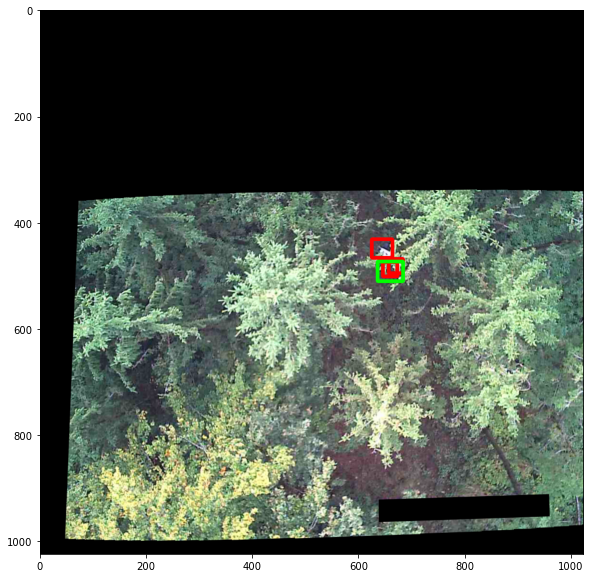

Sample Nr. 1:
[array([[627, 472,  27,  27],
       [617, 424,  36,  34]])]


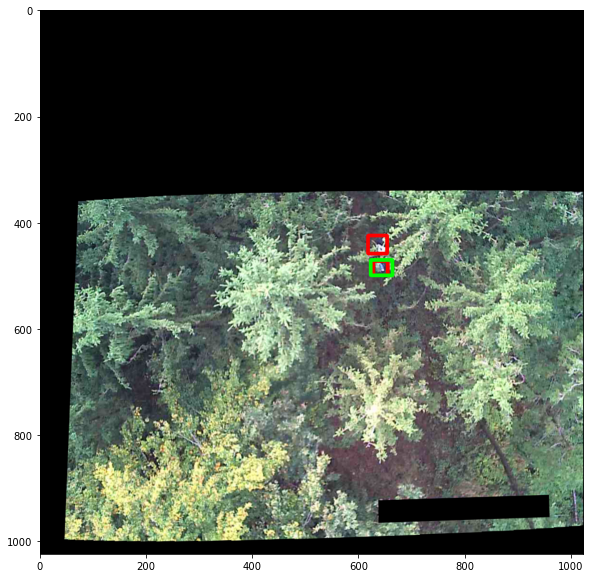

Sample Nr. 2:
[array([[379, 742,  27,  27],
       [585, 480,  27,  27],
       [598, 418,  32,  34]])]


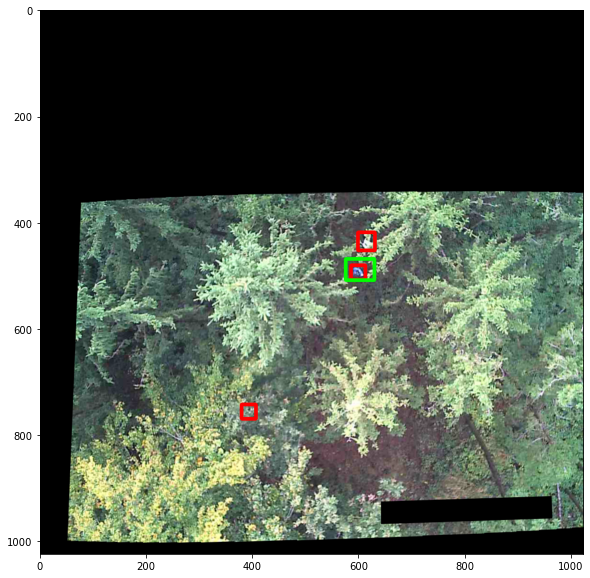

Sample Nr. 3:
[array([[564, 487,  27,  27],
       [589, 401,  33,  40]])]


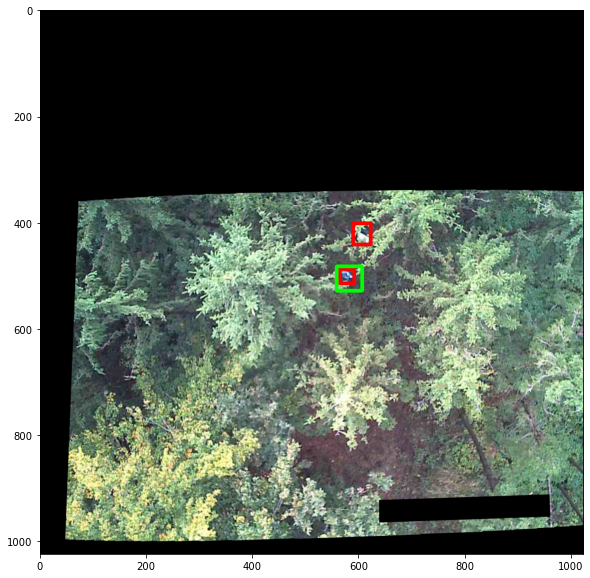

Sample Nr. 4:
[array([[540, 519,  27,  27],
       [571, 415,  37,  38]])]


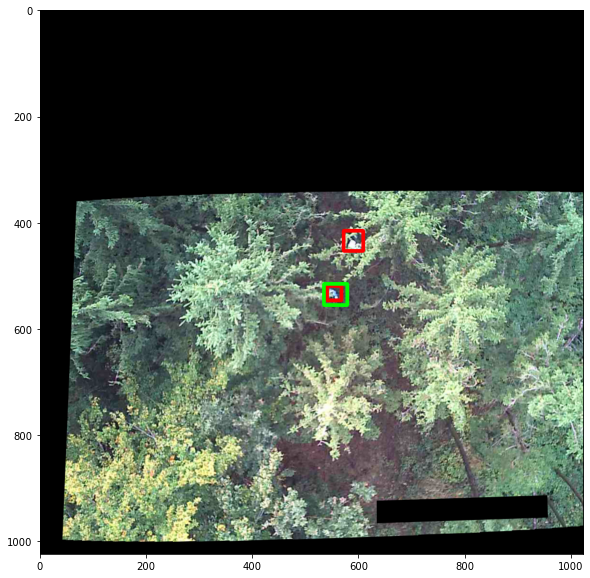

In [24]:
##### RUN TRAINING ROUTINES #####


def train(pretrained_sub_arch: sub_architectures.AbstractTorchArchitecture, show_results=True, load_from_saved=False, save_inference_to_json=False):
    """
    :param AbstractTorchArchitecture pretrained_sub_arch: Pretrained sub-architecture, None if training a sub-architecture
    :param show_results bool: If True results will be displayed
    :param load_from_saved bool: If True loads pre-trained autoencoder from the "state_dict" specified below, otherwise uses uses the pretrained sub-architecture
    :param save_inference_to_json bool: If True performs inference on whole dataset and saves bounding box predictions to JSON file

    """

    # Get PyTorch "device"
    device=get_device()
    print("Device:", torch.cuda.get_device_name(0))

    # Prepare dataset
    #sub = True #Set "sub" to True to get val_data for Sub-Architectures, False for Architectures
    if(pretrained_sub_arch is None):
        dataset = get_dataset(sub=True)
    else:
        dataset = get_dataset(sub=False)

    # Dataloader(s)
    train_loader = val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0, shuffle=True)

    if(pretrained_sub_arch is None):

        ### SUB-ARCHITECTURE TRAINING ROUTINE / MODEL ANALYTICS ###

        trained_model = train_subarchitecture(                    # HYPERPARAMETERS: 
            model=sub_architectures.ConvolutionalAutoencoderV2(), # Untrained model
            optim=torch.optim.Adam,                               # Optimizer
            lr=1e-3,                                              # Learning rate
            num_epochs=25,                                        # Epochs
                                                                
                                                                # DATALOADERS / OPTIONS:
            train_loader=train_loader,                            # Training Dataloader
            val_loader=val_loader,                                # Validation Dataloader
            val_data=dataset,                                     # Dataset(?)
            device=device,                                        # PyTorch "device"
            saved_model_filename="no_histogram_128_trained",      # Model Filename
            plot_training=True,                                   # Plot loss during training
            save_model=True                                       # Save model after training
        )    

        if(show_results):
            output_images = evaluate_model(trained_model, trained_model, val_loader, device) #Evaluate model (Get image results)
            show_n_reconstructed_images(trained_model, output_images, n=3)

        return trained_model

    else:
        ### MAIN ARCHITECTURE TRAINING ROUTINE ###

        autoencoder = sub_architectures.ConvolutionalAutoencoderV2()
        #load_from_saved = False #True: Imports model from below filename, False: Uses "pretrained_sub_arch" argument as model
        show_results = True #True: Displays results, False: Saves predictions

        if(load_from_saved):
            state_dict = torch.load("saved_models/ConvolutionalAutoencoderV2/no_histogram_128_trained")
            autoencoder.load_state_dict(state_dict)
        else:
            autoencoder = pretrained_sub_arch

        #TODO: This might need some formatting..

        importlib.reload(architectures)
        approach = architectures.BasicAutoencoderAnomalyDetectionV1(autoencoder, device=device, image_sizes=(1024,1024)) #Load in autoencoder
        approach_score = architectures.ScoreEnsembleAnomalyDetection([approach], [1])

        if(show_results):
            show_n_bounding_box_results(approach_score, dataset, 5)
        
        if(save_inference_to_json):                                                       
            res = approach_score.infer(dataset, threshold=0.1)
            box_list = [el.tolist() for el in res]
            box_dict = {}
            
            for sample, boxes in zip(dataset, box_list):
                sample_name = os.path.split(sample.sample_path)[-1]
                box_dict[sample_name] = boxes
            
            with open("predictions.json", "w") as fi:
                json.dump(box_dict, fi)

trained_model_sub = train(pretrained_sub_arch=None, show_results=True) 
#pretrained_sub_arch=None if training a sub-architecture, otherwise exchange "None" placeholder with a pre-trained model

trained_model = train(pretrained_sub_arch=trained_model_sub, show_results=True, save_inference_to_json=False, load_from_saved=True)  
#NOTE: When training an Architecture for results, set save_inference_to_json=True to infer the whole dataset (costly)
#As an alternative, show_results=True to see results from a subset of the dataset


#TODO: Add scoring function (Average Precision)